In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

In [2]:
X_train = pickle.load(open('../Data/train_enc.pkl', 'rb'))
X_test = pickle.load(open('../Data/test_enc.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([329, 64])
torch.Size([83, 64])
(329,)
(83,)


In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.1, 0.5, 1.0]
}

ada = AdaBoostClassifier(random_state=42)

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [100, 200, 300, 500]},
             verbose=2)

In [5]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [6]:
best_model = grid_search.best_estimator_
best_model

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)

In [7]:
grid_search.cv_results_

{'mean_fit_time': array([0.42348607, 0.88357313, 1.28999098, 1.96359936, 0.45655775,
        0.89540299, 1.2431523 , 2.07073593, 0.37905931, 0.82876937,
        1.19772251, 1.86528293]),
 'std_fit_time': array([0.01306002, 0.02352144, 0.07050787, 0.01330605, 0.00652768,
        0.00409839, 0.07712797, 0.14570717, 0.0023539 , 0.05132988,
        0.08374091, 0.08384712]),
 'mean_score_time': array([0.05374837, 0.07299725, 0.11272216, 0.16359528, 0.04262908,
        0.07740879, 0.09872357, 0.205441  , 0.0304939 , 0.07491771,
        0.11739771, 0.15581735]),
 'std_score_time': array([0.01764951, 0.00916517, 0.00745349, 0.00792302, 0.00432987,
        0.00741993, 0.00308085, 0.03589026, 0.00869559, 0.01314342,
        0.02315375, 0.02125823]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0,
                    1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
 

In [8]:
train_acc = grid_search.best_score_     # this is train accuracy
print("Train Accuracy:", train_acc)    

Train Accuracy: 0.9210175145954963


In [9]:
from sklearn.metrics import accuracy_score

y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9156626506024096


In [10]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC Score:", auc_score)

AUC Score: 0.8288246268656716


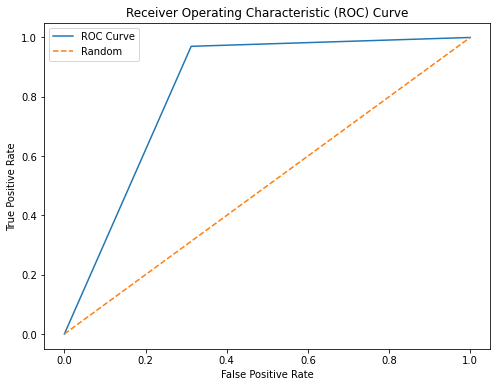

In [11]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

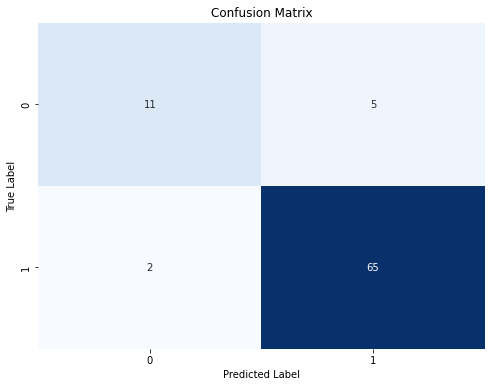

,precision,recall,f1-score,support
0,0.846154,0.687500,0.758621,16.000000
1,0.928571,0.970149,0.948905,67.000000
accuracy,0.915663,0.915663,0.915663,0.915663
macro avg,0.887363,0.828825,0.853763,83.000000
weighted avg,0.912684,0.915663,0.912224,83.000000


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# print classification report as a df
cr = classification_report(y_test, y_pred_test, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cr_df

In [13]:
ada_ae_dict = {
    'model': best_model,
    'train_acc': train_acc,
    'test_acc': test_accuracy,
    'auc_score': auc_score,
    'confusion_matrix': cm,
    'classification_report': cr_df
}

pickle.dump(ada_ae_dict, open('adaboost_AE.pkl', 'wb'))